# Assignment 1

## Imports

In [485]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

## Functions

In [486]:
# RMSE calculator
def calculate_rmse(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rmse

In [487]:
# MEA calculator
def calculate_mae(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

In [488]:
# Ridge Regression using Batch Gradient Descent
def ridge_regression_gradient_descent(X, y, lr, epochs, lambda_reg):
    m, n = X.shape
    theta = np.random.randn(n, 1)  # initializing theta with random values
    cost_history = []

    for epoch in range(epochs):
        gradients = 2/m * X.T.dot(X.dot(theta) - y) + 2*lambda_reg*theta
        theta = theta - lr * gradients
        cost = np.sum((X.dot(theta) - y) ** 2) / m + lambda_reg * np.sum(theta ** 2)
        cost_history.append(cost)
    
    return theta, cost_history

In [489]:
# Exact line search formula
def exact_line_search(X, y, theta, gradients, lambda_reg, step_sizes=np.linspace(0.01, 0.1, 1000)):
    min_cost = np.inf
    optimal_step_size = step_sizes[0]
    for step_size in step_sizes:
        theta_test = theta - step_size * gradients
        cost = np.sum((X.dot(theta_test) - y.reshape(-1, 1)) ** 2) / len(y) + lambda_reg * np.sum(theta_test ** 2)
        if cost < min_cost:
            min_cost = cost
            optimal_step_size = step_size
    return optimal_step_size

In [490]:
# Ridge Regression using Exact Line Search
def ridge_regression_with_exact_line_search(X, y, epochs, lambda_reg):
    m, n = X.shape
    theta = np.random.randn(n, 1)  # initializing theta with random values
    cost_history = []

    for epoch in range(epochs):
        gradients = 2/m * X.T.dot(X.dot(theta) - y) + 2*lambda_reg*theta
        step_size = exact_line_search(X, y, theta, gradients, lambda_reg)
        theta = theta - step_size * gradients
        cost = np.sum((X.dot(theta) - y) ** 2) / m + lambda_reg * np.sum(theta ** 2)
        cost_history.append(cost)
    
    return theta, cost_history

## Datasets

In [491]:
## training and test sets from the zip file
poly_test = pd.read_csv("polynomial_regression_test_data.csv").filter(items=['x', 'y'])
poly_train = pd.read_csv("polynomial_regression_train_data.csv").filter(items=['x', 'y'])
ridge_test = pd.read_csv("ridge_regression_test_data.csv").filter(items=['x', 'y'])
ridge_train = pd.read_csv("ridge_regression_train_data.csv").filter(items=['x', 'y'])

## Ridge Regression Variants

The goal of this assignment is to learn how to implement polynomial (linear and higher degree) re-
gression with regularization (i.e., ridge regression) in closed form and gradient descent. Additionally,
bonus on the assignment is to learn the exact line search which is a variant on the gradient descent
that should be faster. Bonus marks will be used to amend any loss of marks in other assignments,
project, exams or attendance.

### Ridge Regression (Linear) Closed Form

In [492]:
# Training dataframes parsed for x, and y values
X_train = ridge_train.filter(items=['x'])
y_train = ridge_train['y'].values

# Test dataframes parsed for x, and y values
X_test = ridge_test.filter(items=['x'])
y_test = ridge_test['y'].values

# Adding a column of ones to X_train and X_test for the intercept
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

# Ridge Regression variables
lambda_param = 0.1  # Regularization variables
I = np.eye(X_train.shape[1])  # Matrix

# Closed form solution
beta = np.linalg.inv(X_train.T @ X_train + lambda_param * I) @ X_train.T @ y_train

# Calculating the predictions 
y_pred_train = X_train @ beta
y_pred_test = X_test @ beta

# intercept and coefficient are in beta var
results_bf = pd.DataFrame({"Intercept": [beta[0]], "Coef": [beta[1]]})
results_bf

,Intercept,Coef
0,8.257565,1.318218


In [493]:
# Calculating RMSE and MAE for training and test data
rmse_train = calculate_rmse(y_train, y_pred_train)
mae_train = calculate_mae(y_train, y_pred_train)
rmse_test = calculate_rmse(y_test, y_pred_test)
mae_test = calculate_mae(y_test, y_pred_test)

# Creating a DataFrame to display RMSEs and MAEs
results_df = pd.DataFrame({"Train RMSE": [rmse_train], "Train MAE": [mae_train], "Test RMSE": [rmse_test], "Test MAE": [mae_test]})

# Results
results_df

,Train RMSE,Train MAE,Test RMSE,Test MAE
0,10.370433,8.120414,10.375305,8.372365


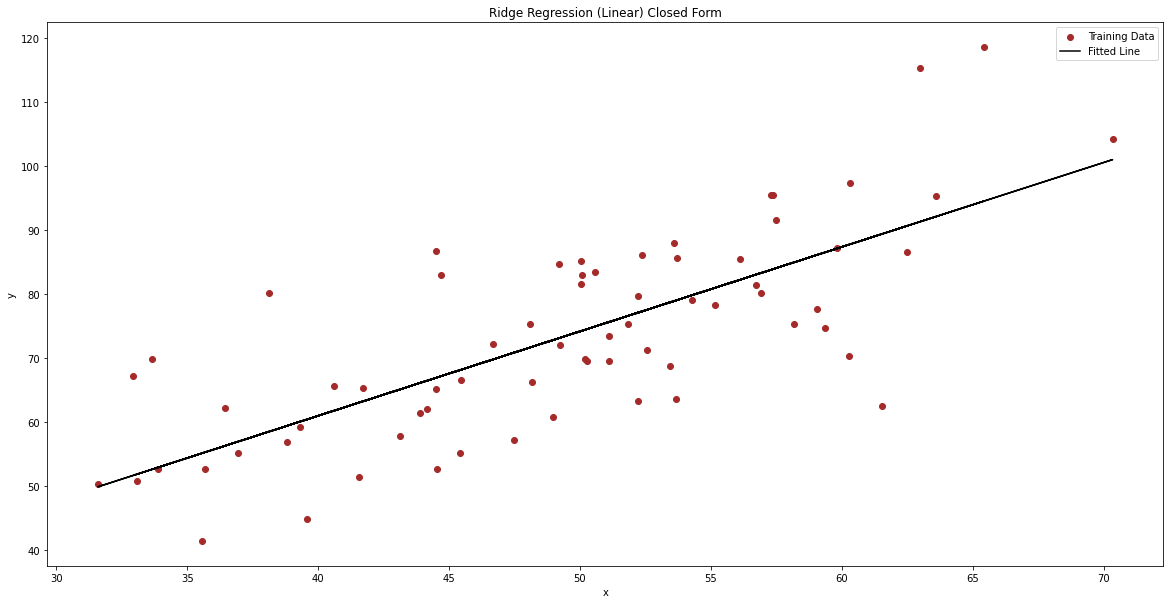

In [494]:
# Plotting
plt.figure(figsize=(20, 10))
plt.scatter(X_train[:, 1], y_train, color='brown', label='Training Data')
plt.plot(X_train[:, 1], y_pred_train, color='black', label='Fitted Line')
## Labels for axis
plt.xlabel('x')
plt.ylabel('y')
# Title
plt.title('Ridge Regression (Linear) Closed Form')
plt.legend()
plt.show()

### Polynomial Regression Closed Form

In [495]:
# Training dataframes parsed for x, and y values
x_train, y_train = poly_train['x'].values, poly_train['y'].values
# Test dataframes parsed for x, and y values
x_test, y_test = poly_test['x'].values, poly_test['y'].values

# Generate polynomial features up to the fifth degree
poly = PolynomialFeatures(degree=5, include_bias=False) ## sklearns used for preprocessing
x_train_poly = poly.fit_transform(x_train[:, np.newaxis])
x_test_poly = poly.transform(x_test[:, np.newaxis])

# Ridge Regression parameters
lambda_param = 0.0001  # Regularization strength

# Add a column of ones to the input features to account for the bias term
x_train_poly_bias = np.hstack([np.ones((x_train_poly.shape[0], 1)), x_train_poly])
x_test_poly_bias = np.hstack([np.ones((x_test_poly.shape[0], 1)), x_test_poly])

# Compute the Ridge Regression coefficients (theta) using the closed-form solution
I = np.eye(x_train_poly_bias.shape[1])
I[0, 0] = 0  # Avoid regularizing the bias term
theta = np.linalg.inv(x_train_poly_bias.T.dot(x_train_poly_bias) + lambda_param * I).dot(x_train_poly_bias.T).dot(y_train)

# Predictions for training and test datasets
y_train_pred = x_train_poly_bias.dot(theta)
y_test_pred = x_test_poly_bias.dot(theta)

# intercept and coefficients are in theta var
results_bf = pd.DataFrame({"Intercept": [theta[0]], "x1": [theta[1]], "x2": [theta[2]], "x3": [theta[3]], "x4": [theta[4]], "x5": [theta[5]] })
results_bf

,Intercept,x1,x2,x3,x4,x5
0,-0.517348,3.431205,-2.184987,0.483392,-0.043845,0.001395


In [496]:
# Calculating RMSE and MAE for training and test data
rmse_train = calculate_rmse(y_train, y_train_pred)
mae_train = calculate_mae(y_train, y_train_pred)
rmse_test = calculate_rmse(y_test, y_test_pred)
mae_test = calculate_mae(y_test, y_test_pred)

# Generate a range of values for x to plot the polynomial curve
x_range = np.linspace(x_train.min(), x_train.max(), 400)
x_range_poly = poly.transform(x_range[:, np.newaxis])
x_range_poly_bias = np.hstack([np.ones((x_range_poly.shape[0], 1)), x_range_poly])

# Predict y values for the generated range of x values
y_range_pred = x_range_poly_bias.dot(theta)

# Creating a DataFrame to display RMSEs and MAEs
results_df = pd.DataFrame({"Train RMSE": [rmse_train], "Train MAE": [mae_train], "Test RMSE": [rmse_test], "Test MAE": [mae_test]})

# Results
results_df

,Train RMSE,Train MAE,Test RMSE,Test MAE
0,0.290398,0.240358,0.271824,0.223298


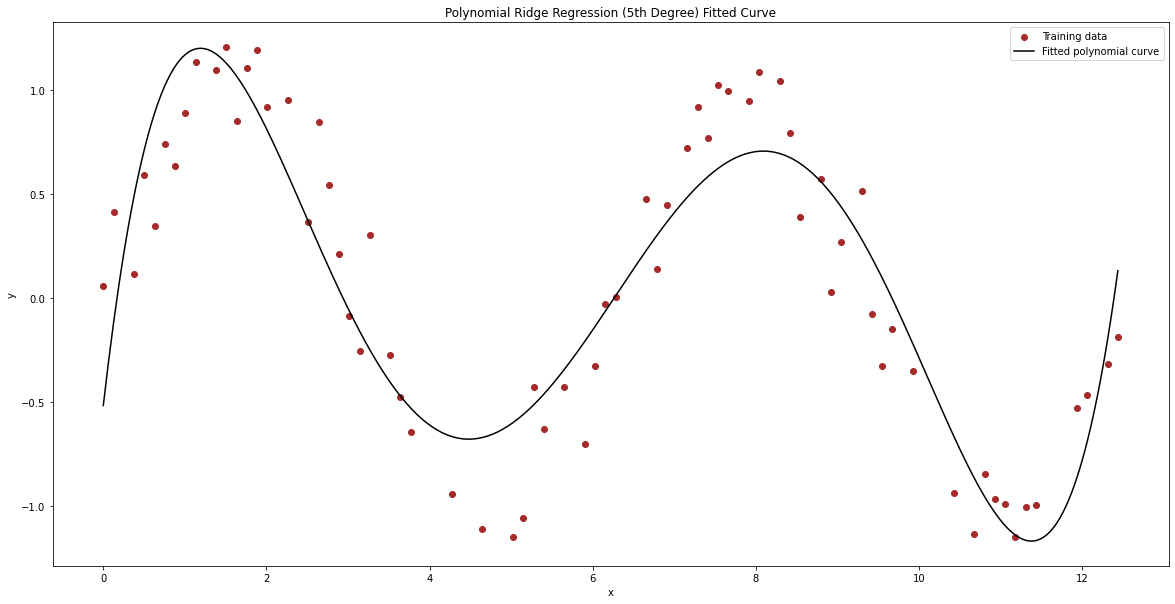

In [497]:
# Plotting
plt.figure(figsize=(20, 10))
plt.scatter(x_train, y_train, color='brown', label='Training data')
plt.plot(x_range, y_range_pred, color='black', label='Fitted polynomial curve')
# Label the axis
plt.xlabel('x')
plt.ylabel('y')
# Title
plt.title('Polynomial Ridge Regression (5th Degree) Fitted Curve')
plt.legend()
plt.show()

### Ridge Regression with Gradient Descent

In [498]:
# Training and test dataframes parsed for x, and y values
x_train = ridge_train['x'].values.reshape(-1, 1)
y_train = ridge_train['y'].values.reshape(-1, 1)
x_test = ridge_test['x'].values.reshape(-1, 1)
y_test = ridge_test['y'].values.reshape(-1, 1)

# Had to scale to get the result measurements because of nan errors

# Scaling x
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

# Adding a bias term to the scaled feature matrices
X_train_scaled_bias = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_scaled_bias = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

# The ridge regression with scaling x
theta, cost_history = ridge_regression_gradient_descent(X_train_scaled_bias, y_train, lr=0.01, epochs=1000, lambda_reg=0.001)

# Predictions
predictions_train = X_train_scaled_bias.dot(theta)
predictions_test = X_test_scaled_bias.dot(theta)

# intercept and coefficients are in theta var
results_bf = pd.DataFrame({"Intercept": [theta[0]], "Coef": [theta[1]]})
results_bf

,Intercept,Coef
0,[73.17361562126234],[11.647516454208171]


In [499]:
# Calculating RMSE and MAE for training and test data
rmse_train = calculate_rmse(y_train, predictions_train)
mae_train = calculate_mae(y_train, predictions_train)
rmse_test = calculate_rmse(y_test, predictions_test)
mae_test = calculate_mae(y_test, predictions_test)

# Creating a DataFrame to display RMSEs and MAEs
results_df = pd.DataFrame({"Train RMSE": [rmse_train], "Train MAE": [mae_train], "Test RMSE": [rmse_test], "Test MAE": [mae_test]})

# Display results
results_df

,Train RMSE,Train MAE,Test RMSE,Test MAE
0,10.37048,8.120745,10.371537,8.361684


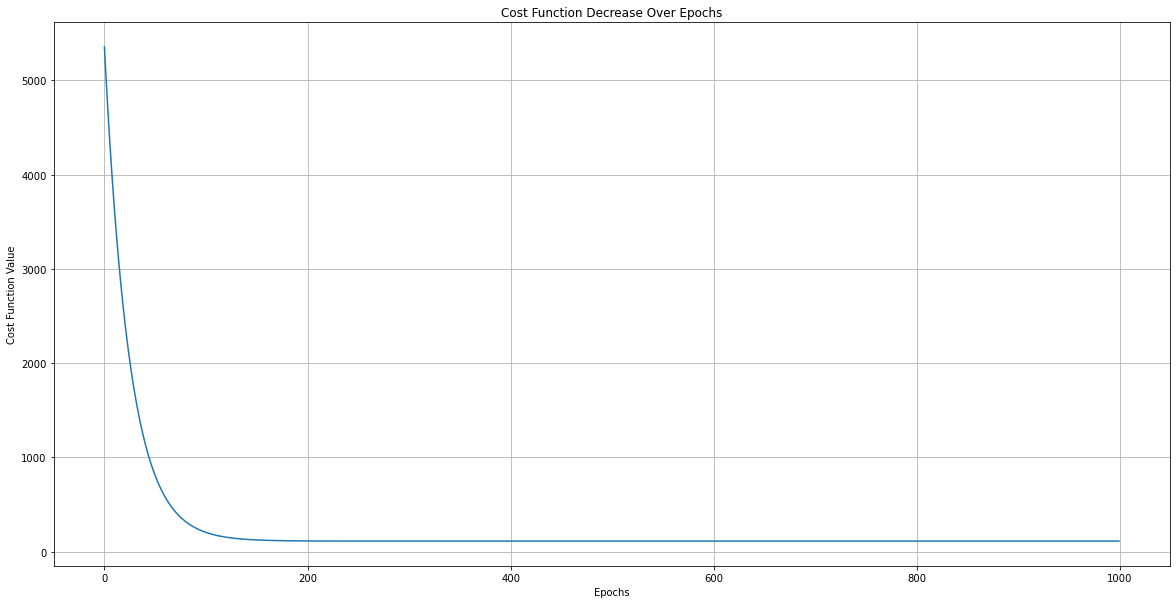

In [500]:
# Plotting the cost function over epochs
plt.figure(figsize=(20, 10))
plt.plot(cost_history)
# Title
plt.title('Cost Function Decrease Over Epochs')
# Labels for axis
plt.xlabel('Epochs')
plt.ylabel('Cost Function Value')
plt.grid(True)
plt.show()

### Exact Line Search

In [501]:
# Applying exact line search with ridge regression
theta_els, cost_history_els = ridge_regression_with_exact_line_search(X_train_scaled_bias, y_train, epochs=1000, lambda_reg=0.01)

# Predictions using the new model
predictions_train_els = X_train_scaled_bias.dot(theta_els)
predictions_test_els = X_test_scaled_bias.dot(theta_els)

# intercept and coefficients are in theta var
results_bf = pd.DataFrame({"Intercept": [theta_els[0]], "Coef": [theta_els[1]]})
results_bf

,Intercept,Coef
0,[72.52157362104847],[11.543726722510208]


In [502]:
# Evaluation metrics for the new model
rmse_train_els = calculate_rmse(y_train, predictions_train_els)
mae_train_els = calculate_mae(y_train, predictions_train_els)
rmse_test_els = calculate_rmse(y_test, predictions_test_els)
mae_test_els = calculate_mae(y_test, predictions_test_els)

# Creating a DataFrame to display RMSEs and MAEs
results_df = pd.DataFrame({"Train RMSE": [rmse_train_els], "Train MAE": [mae_train_els], "Test RMSE": [rmse_test_els], "Test MAE": [mae_test_els]})

# Results
results_df

,Train RMSE,Train MAE,Test RMSE,Test MAE
0,10.396184,8.056888,10.414215,8.439543


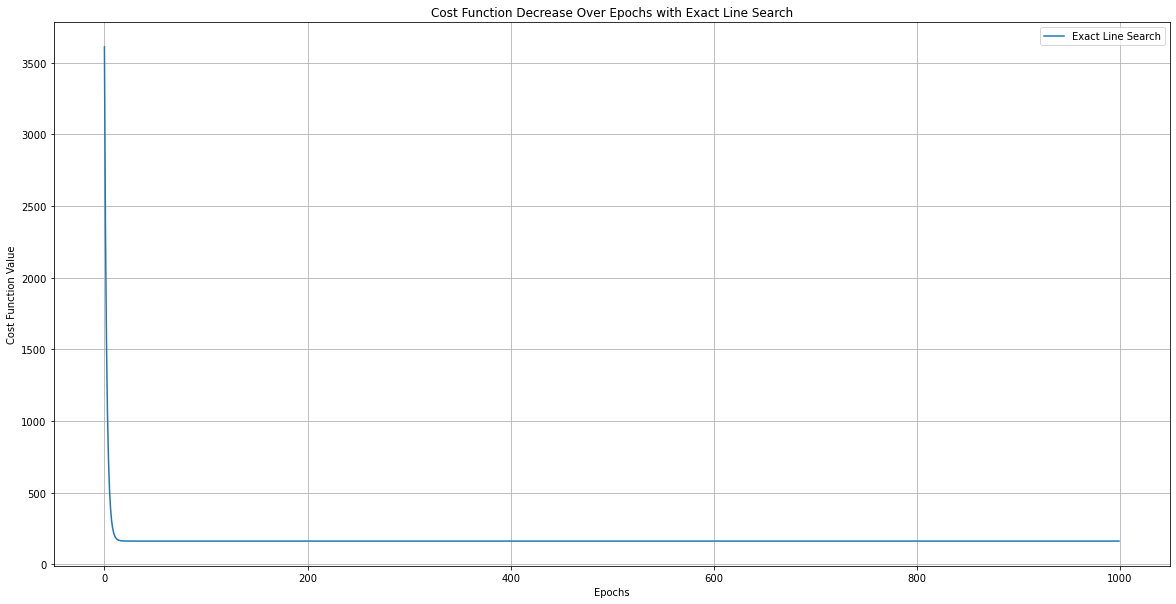

In [503]:
# Plotting the cost function over epochs for the exact line search method
plt.figure(figsize=(20, 10))
plt.plot(cost_history_els, label='Exact Line Search')
# Title
plt.title('Cost Function Decrease Over Epochs with Exact Line Search')
# Label for axis
plt.xlabel('Epochs')
plt.ylabel('Cost Function Value')
plt.legend()
plt.grid(True)
plt.show()